In [1]:
import gymnasium as gym
import numpy as np
import ipywidgets as widgets
import sys

sys.path.append('../')
import support_modules as sm

# Acrobot

## Description
<div style="text-align: justify">    
The Acrobot environment is based on Sutton’s work in “Generalization in Reinforcement Learning: Successful Examples Using Sparse Coarse Coding” and Sutton and Barto’s book. The system consists of two links connected linearly to form a chain, with one end of the chain fixed. The joint between the two links is actuated. The goal is to apply torques on the actuated joint to swing the free end of the linear chain above a given height while starting from the initial state of hanging downwards.

As seen in the Gif: two blue links connected by two green joints. The joint in between the two links is actuated. The goal is to swing the free end of the outer-link to reach the target height (black horizontal line above system) by applying torque on the actuator.
</div>

https://gymnasium.farama.org/environments/classic_control/acrobot/

# Random Policy

### Single episode

In [ ]:
env = gym.make('Acrobot-v1', render_mode='human')
state, _ = env.reset()
done = False

while not done:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    env.render()
    
    done = sm.evaluate_done(terminated,truncated)

env.close()

### 1000 episodes

In [ ]:
env = gym.make('Acrobot-v1',render_mode=None)

rewards = list()

for episode in range(1000):
    state, _ = env.reset()
    ep_reward = 0
    done = False

    while not done:
        action = env.action_space.sample()
        observation, reward, terminated, truncated, info = env.step(action)
        ep_reward += reward
        
        done = sm.evaluate_done(terminated,truncated)
    
    rewards.append(ep_reward)

env.close()
print(f'Success rate: {sum(success)/len(success)}')
print(f'Average reward: {sum(rewards)/len(rewards)}')
env.close()

# [Beta] Q-Learning

In [ ]:
# Fixed Parameters
LEARNING_RATE = 0.1         # How fast does the agent learn
DISCOUNT = 0.95             # How important are future actions

EPISODES = 10000            # Number of episodes

epsilon = 0.5                           # Exploration rate
START_EPSILON_DECAYING = 1              # First episode at which decay epsilon
END_EPSILON_DECAYING = 1250             # Last episode at which decay epsilon

In [2]:
# Flexible Parameters (ipywidgets)
EPISODES_W = widgets.IntSlider(value=400000, min=5000, max=500000, step=50, description='Number Episodes', 
                               style={'handle_color':'magenta','description_width':'initial'}, layout={'width': '40%'})

LEARNING_RATE_W = widgets.FloatSlider(value=0.05, min=0, max=1, step=0.01, description='Learning rate',
                                      style={'handle_color':'magenta','description_width':'initial'}, layout={'width': '40%'})
DISCOUNT_W = widgets.FloatSlider(value=0.95, min=0, max=1, step=0.01, description='Discount factor',
                                 style={'handle_color':'magenta','description_width':'initial'}, layout={'width': '40%'})

epsilon_W = widgets.FloatSlider(value=1, min=0, max=1, step=0.05, description='Exploration rate',
                                style={'handle_color':'magenta','description_width':'initial'}, layout={'width': '40%'})

display(EPISODES_W,LEARNING_RATE_W,DISCOUNT_W,epsilon_W)

START_EPSILON_DECAYING = 1                      # First episode at which decay epsilon

IntSlider(value=400000, description='Number Episodes', layout=Layout(width='40%'), max=500000, min=5000, step=…

FloatSlider(value=0.05, description='Learning rate', layout=Layout(width='40%'), max=1.0, step=0.01, style=Sli…

FloatSlider(value=0.95, description='Discount factor', layout=Layout(width='40%'), max=1.0, step=0.01, style=S…

FloatSlider(value=1.0, description='Exploration rate', layout=Layout(width='40%'), max=1.0, step=0.05, style=S…

In [3]:
env = gym.make('Acrobot-v1', render_mode=None)

discrete_partitions = 35

# Retrieving 
EPISODES = EPISODES_W.value; LEARNING_RATE = LEARNING_RATE_W.value
DISCOUNT = DISCOUNT_W.value; epsilon = epsilon_W.value
epsilon_decaying_value = epsilon / ((EPISODES//1.5) - START_EPSILON_DECAYING)     # Amount of decayment of epsilon    

LEARNING_RATE = 0.001
DISCOUNT = 0.999


# Generate the discrete state space and the interval of each discrete space
discrete_state_space,discrete_state_intervals = sm.Q_Learning_Agent.generate_discrete_states(discrete_partitions,env)

# Generate the q_table
q_table = sm.Q_Learning_Agent.generate_q_table('random',env.action_space.n,discrete_state_space,low=-2,high=0)
# q_table = sm.Q_Learning_Agent.generate_q_table('init_value',env,discrete_state_space,value=-2)

# Rewards
ep_rewards = list()
success = list()
epsilons = list()


### Training
for episode in range(EPISODES):
    episode_reward = 0
    state, info = env.reset()
    discrete_state = sm.Q_Learning_Agent.get_discrete_state(state,env,discrete_state_intervals,discrete_partitions)        # Discrete initial state
    done = False
    
    while not done: 

        if np.random.random() > epsilon:                    # Randomize actions with epsilon
            action = np.argmax(q_table[discrete_state])     # Action taken from the argmax of the current state
        else:
            action = env.action_space.sample()              # Action taken at random
        
        new_state, reward, terminated, truncated, info = env.step(action)       # Retrieve information
        done = sm.evaluate_done(terminated,truncated)

        episode_reward += reward
        
        new_discrete_state = sm.Q_Learning_Agent.get_discrete_state(new_state,env,discrete_state_intervals,discrete_partitions)  # Discretize new state
        
        if not done: 
            q_table = sm.Q_Learning_Agent.update_q_table(q_table,discrete_state,new_discrete_state,action,reward,LEARNING_RATE,DISCOUNT)
        
        elif terminated:
            q_table[discrete_state + (action, )] = 0        # Update value when goal is reached
        
        discrete_state = new_discrete_state                 # Update state
    
    epsilon = sm.Q_Learning_Agent.decay_epsilon(epsilon,episode,epsilon_decaying_value,START_EPSILON_DECAYING,EPISODES//1.5)
    
    ep_rewards.append(episode_reward)
    success.append(terminated)
    epsilons.append(epsilon)
     
env.close()

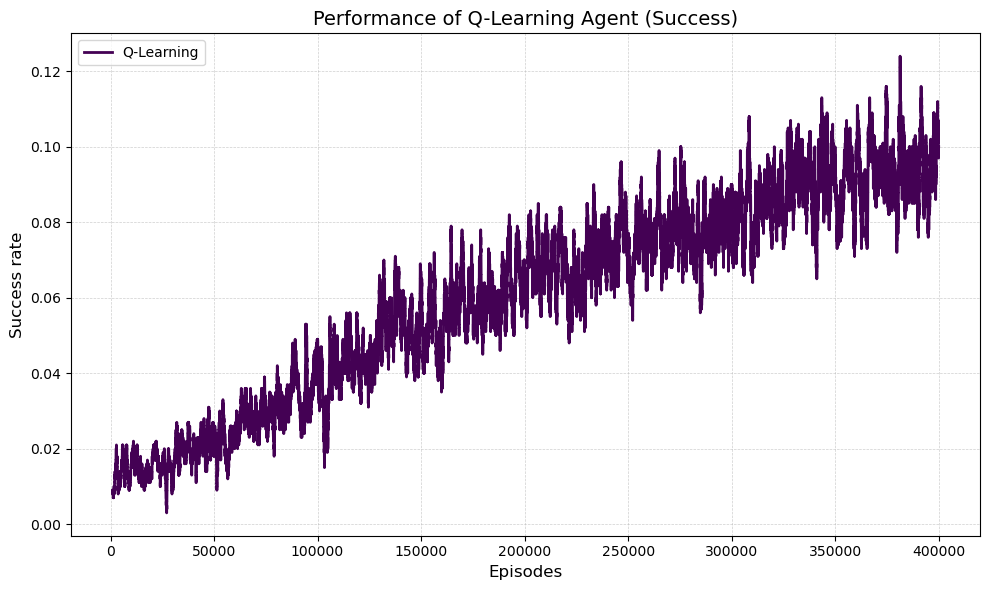

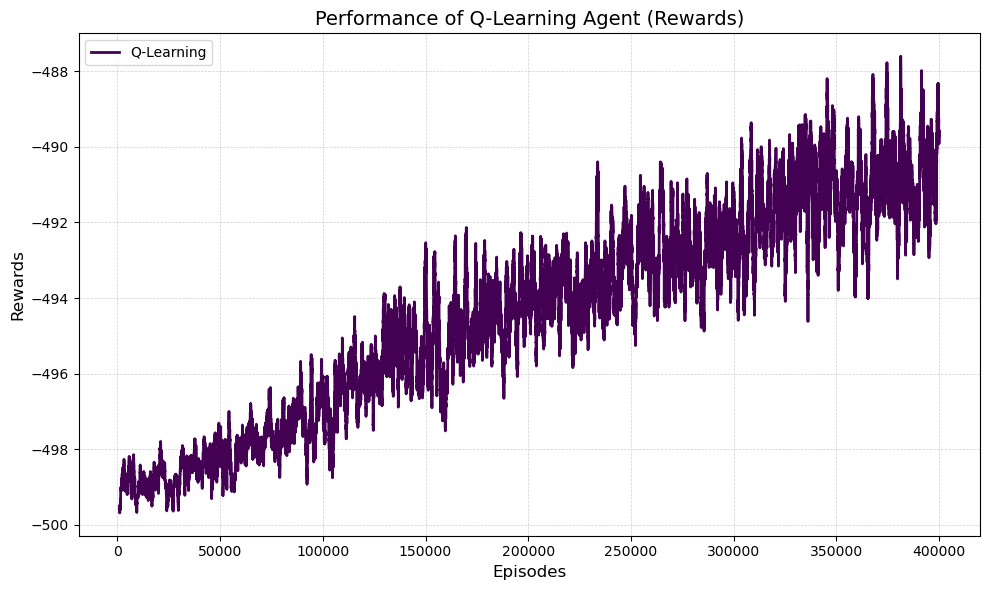

In [4]:
# Visualizing training results
sm.visualizations.plot_moving_average([success],['Q-Learning'],1000,
                                      title='Performance of Q-Learning Agent (Success)',ylabel='Success rate')
sm.visualizations.plot_moving_average([ep_rewards],['Q-Learning'],1000,
                                      title='Performance of Q-Learning Agent (Rewards)',ylabel='Rewards')
# sm.visualizations.plot_series([epsilons],['epsilon'],title='Exploration Rate Decaying', ylabel='epsilon')

### Testing

### Visualizing Trained Agent

In [8]:
env = gym.make('Acrobot-v1', render_mode='human')
state, _ = env.reset()
discrete_state = sm.Q_Learning_Agent.get_discrete_state(state,env,discrete_state_intervals,discrete_partitions)
done = False

while not done:
    action = np.argmax(q_table[discrete_state])
    state, reward, terminated, truncated, info = env.step(action)
    discrete_state = sm.Q_Learning_Agent.get_discrete_state(state,env,discrete_state_intervals,discrete_partitions)
    env.render()
    
    done = sm.evaluate_done(terminated,truncated)

env.close()


### Testing Agent on 100 New Episodes

In [6]:
env = gym.make('Acrobot-v1', render_mode=None)
testing_success = list()
testing_rewards = list()

for episode in range(100):
    state, _ = env.reset()
    discrete_state = sm.Q_Learning_Agent.get_discrete_state(state,env,discrete_state_intervals,discrete_partitions)
    done = False
    ep_reward = 0

    while not done:
        action = np.argmax(q_table[discrete_state])
        state, reward, terminated, truncated, info = env.step(action)
        discrete_state = sm.Q_Learning_Agent.get_discrete_state(state,env,discrete_state_intervals,discrete_partitions)

        ep_reward += reward
        
        done = sm.evaluate_done(terminated,truncated)

    testing_success.append(terminated)
    testing_rewards.append(ep_reward)
env.close()

print(f'Success rate of Q-Learning Agent on 100 episodes: {round(sum(testing_success)/len(testing_success),2)}')
print(f'Average rewards of Q-Learning Agent on 100 episodes: {round(sum(testing_rewards)/len(testing_rewards),2)}')

Success rate of Q-Learning Agent on 100 episodes: 0.08
Average rewards of Q-Learning Agent on 100 episodes: -490.27


# Stable Baselines 3

## Asynchronous Advantage Actor Critic (A2C)

In [4]:
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env

vec_env = make_vec_env("Acrobot-v1", n_envs=4)

A2C_model = A2C("MlpPolicy", vec_env, verbose=0)
A2C_model.learn(total_timesteps=100_000)

env = gym.make('Acrobot-v1', render_mode=None)
testing_success = list()
testing_rewards = list()

for episode in range(100):
    state, _ = env.reset()
    done = False
    ep_reward = 0

    while not done:
        action, _state = A2C_model.predict(state, deterministic=True)
        state, reward, terminated, truncated, info = env.step(action)

        ep_reward += reward
        
        done = sm.evaluate_done(terminated,truncated)

    testing_success.append(terminated)
    testing_rewards.append(ep_reward)
env.close()

print(f'Success rate of (trained) A2C Agent on 100 episodes: {round(sum(testing_success)/len(testing_success),2)}')
print(f'Average rewards of (trained) A2C Agent on 100 episodes: {round(sum(testing_rewards)/len(testing_rewards),2)}')

Success rate of (trained) A2C Agent on 100 episodes: 0.15
Average rewards of (trained) A2C Agent on 100 episodes: -439.09


## Deep Q-Network (DQN)

In [5]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env

vec_env = make_vec_env("Acrobot-v1", n_envs=4)

DQN_model = DQN("MlpPolicy", vec_env, verbose=0)
DQN_model.learn(total_timesteps=100_000)

env = gym.make('Acrobot-v1', render_mode=None)
testing_success = list()
testing_rewards = list()

for episode in range(100):
    state, _ = env.reset()
    done = False
    ep_reward = 0

    while not done:
        action, _state = DQN_model.predict(state, deterministic=True)
        state, reward, terminated, truncated, info = env.step(action)

        ep_reward += reward
        
        done = sm.evaluate_done(terminated,truncated)

    testing_success.append(terminated)
    testing_rewards.append(ep_reward)
env.close()

print(f'Success rate of (trained) DQN Agent on 100 episodes: {round(sum(testing_success)/len(testing_success),2)}')
print(f'Average rewards of (trained) DQN Agent on 100 episodes: {round(sum(testing_rewards)/len(testing_rewards),2)}')

Success rate of (trained) DQN Agent on 100 episodes: 1.0
Average rewards of (trained) DQN Agent on 100 episodes: -151.49


## Proximal Policy Optimization (PPO)

In [4]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Parallel environments
vec_env = make_vec_env("Acrobot-v1", n_envs=4)

PPO_model = PPO("MlpPolicy", vec_env, verbose=0)
PPO_model.learn(total_timesteps=100_000)

env = gym.make('Acrobot-v1', render_mode=None)
testing_success = list()
testing_rewards = list()

for episode in range(100):
    state, _ = env.reset()
    done = False
    ep_reward = 0

    while not done:
        action, _state = PPO_model.predict(state, deterministic=True)
        state, reward, terminated, truncated, info = env.step(action)

        ep_reward += reward
        
        done = sm.evaluate_done(terminated,truncated)

    testing_success.append(terminated)
    testing_rewards.append(ep_reward)
env.close()

print(f'Success rate of (trained) PPO Agent on 100 episodes: {round(sum(testing_success)/len(testing_success),2)}')
print(f'Average rewards of (trained) PPO Agent on 100 episodes: {round(sum(testing_rewards)/len(testing_rewards),2)}')

Success rate of (trained) PPO Agent on 100 episodes: 1.0
Average rewards of (trained) PPO Agent on 100 episodes: -92.01


## Visualize Trained Stable Baselines Models

In [7]:
model = DQN_model

env = gym.make('Acrobot-v1', render_mode='human')
state, _ = env.reset()
done = False

while not done:
    action, _state = model.predict(state, deterministic=True)
    state, reward, terminated, truncated, info = env.step(action)
    env.render()
    
    done = sm.evaluate_done(terminated,truncated)

env.close()